# inter-run comparisons of N contained in phytoplankton
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
import gsw
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [2]:
plist=['Sentry Shoal','S3','Central node','Central SJDF']

In [3]:
flist=['BritishColumbiaFerries_Tsawwassen-DukePoint_Thermosalinograph_20150905T182238Z_20160527T201626Z-clean.csv',
    'BritishColumbiaFerries_Tsawwassen-DukePoint_Thermosalinograph_20160527T201636Z_20161115T220743Z-clean.csv']

In [35]:
dfs=list()
for ii in range(0,len(flist)):
    dfs.append(pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/thermosalinograph/nearSurface/search3951776/'+flist[ii],
        skiprows=102,header=None,#usecols=[0,1,2,3,4,5,6,7,8,9,10],
        names=('TimeUTC','Conductivity','ConductivityQCFlag','Lat', 'LatQCFlag', 'Lon', 'LonQCFlag', 
               'PracticalSalinity_psu', 'PracticalSalQCFlag', 'Sound Speed','SoundSpeedQCFlag',
               'Temperature_C', 'TQCFlag','Lat2', 'Lat2QCFlag', 'Lon2', 'Lon2QCFlag',)))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
df=pd.concat(dfs,ignore_index=True)

In [37]:
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]

In [38]:
df=df.assign(dts=dts)

In [50]:
#df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
#df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')
df['Lat']=pd.to_numeric(df['Lat2'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon2'],errors='coerce')

In [51]:
df.loc[df['Lat']>0].count()

TimeUTC                  1704159
Conductivity             1704159
ConductivityQCFlag       1704159
Lat                      1704159
LatQCFlag                1704159
Lon                      1704159
LonQCFlag                1704159
PracticalSalinity_psu    1704159
PracticalSalQCFlag       1704159
Sound Speed              1704159
SoundSpeedQCFlag         1704159
Temperature_C            1704159
TQCFlag                  1704159
Lat2                     1704159
Lat2QCFlag               1704159
Lon2                     1704159
Lon2QCFlag               1704159
dts                      1704159
dtype: int64

In [52]:
sa=[gsw.SA_from_SP(i,1.0,k,l) for i,k,l in zip(df['PracticalSalinity_psu'],df['Lon'],df['Lat'])]
ct=[gsw.CT_from_t(i,j,1.0) for i,j in zip(sa,df['Temperature_C'])]
df['SA']=sa
df['CT']=ct

In [53]:
df.head()

,TimeUTC,Conductivity,ConductivityQCFlag,Lat,LatQCFlag,Lon,LonQCFlag,PracticalSalinity_psu,PracticalSalQCFlag,Sound Speed,SoundSpeedQCFlag,Temperature_C,TQCFlag,Lat2,Lat2QCFlag,Lon2,Lon2QCFlag,dts,SA,CT
0,2015-09-05T18:22:38.985Z,2.99149,1,49.162402,9,-123.601308,9,23.7007,1,NaN,9,14.5804,1,49.162402,8,-123.601308,8,2015-09-05 18:22:38,23.815584,14.839158
1,2015-09-05T18:22:48.979Z,2.98504,1,49.162836,9,-123.602507,9,23.6448,1,NaN,9,14.5798,1,49.162836,8,-123.602507,8,2015-09-05 18:22:48,23.759414,14.839844
2,2015-09-05T18:22:58.984Z,2.98358,1,49.163202,9,-123.603641,9,23.6205,1,NaN,9,14.5988,1,49.163202,8,-123.603641,8,2015-09-05 18:22:58,23.734996,14.859697
3,2015-09-05T18:23:08.998Z,2.97982,1,49.163570,9,-123.604810,9,23.5854,1,NaN,9,14.6026,1,49.163570,8,-123.604810,8,2015-09-05 18:23:08,23.699727,14.864369
4,2015-09-05T18:23:18.993Z,2.97057,1,49.164037,9,-123.606008,9,23.4959,1,NaN,9,14.6172,1,49.164037,8,-123.606008,8,2015-09-05 18:23:18,23.609793,14.881269


In [54]:
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01
iidfnd=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)

(736330.0, 736695.0)

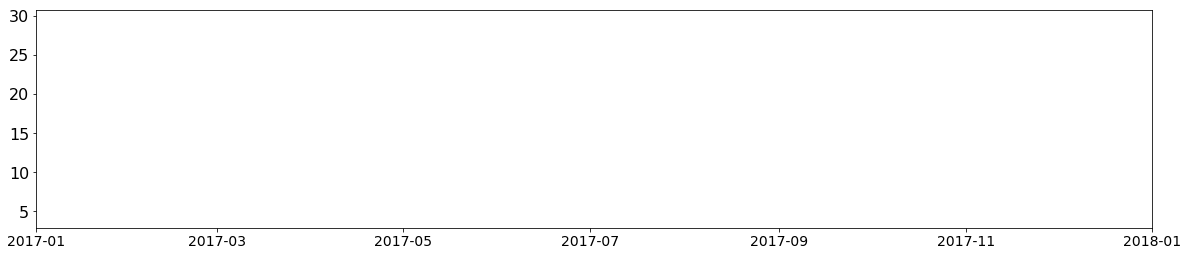

In [55]:
fig,ax=plt.subplots(1,1,figsize=(20,4))
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['CT']],'k*')
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Temperature_C']],'b*',alpha=.01)
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['SA']],'r*')
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['PracticalSalinity_psu']],'m*',alpha=.01)
ax.set_xlim(dt.datetime(2017,1,1),dt.datetime(2018,1,1))
#dt.datetime(2014,12,31)+dt.timedelta(days=65),dt.datetime(2014,12,31)+dt.timedelta(days=75)

In [56]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]
#stm=np.shape(tmask)

In [57]:
#saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/comparePhytoN/'
baseloc='/data/eolson/MEOPAR/SS36runs/CedarRuns/'
dirname1='hindcast2016P'
dirname2='hindcast2016'
dirnames=(dirname1,dirname2)
#dirnames=('spring2015_NewSink','spring2015_slowPP','spring2015_KhT','spring2015_diatHS')
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
#spaths={'spring2015_NewSink':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_NewSink/',
#    'spring2015_KhT':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_KhT/',
#    'spring2015_uzoo':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo/',
#    'spring2015_uzoo2':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo2/',
#    'spring2015_slowPP':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_slowPP/',
#    'spring2015_lowMuNano':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_lowMuNano/',
#    'spring2015_SMELTBFastSink':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_SMELTBFastSink/',
#    'spring2015_uzPref':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzPref/',
#    'spring2015_hiNH':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_hiNH/'}
ff=dict()
for idir in dirnames:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #try:
    #    pl='Total'
    #    ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #except:
    #    pass

/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016P_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016P_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016P_CentralNode.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016P_CentralSJDF.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_CentralNode.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_CentralSJDF.nc


In [58]:
spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc'

'/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_CentralSJDF.nc'

In [59]:
spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc'

'/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_CentralSJDF.nc'

In [60]:
times=dict()
for idir in dirnames:
    f=ff[idir]['S3']
    torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print(torig)
    times[idir]=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00
1900-01-01 00:00:00


In [61]:
lcol={dirname1:{'votemper':'darkgreen','vosaline':'mediumblue'},
     dirname2:{'diatoms':'c','flagellates':'blueviolet','ciliates':'orange'}}
lsty={dirname1:'-',
      dirname2:'-'}

In [62]:
tmins=list()
tmaxs=list()
for idir in dirnames:
    tmins.append(times[idir][0])
    tmaxs.append(times[idir][-1])
xl=(np.min(np.array(tmins)),np.max(np.array(tmaxs)))

(735995.0, 736085.0)

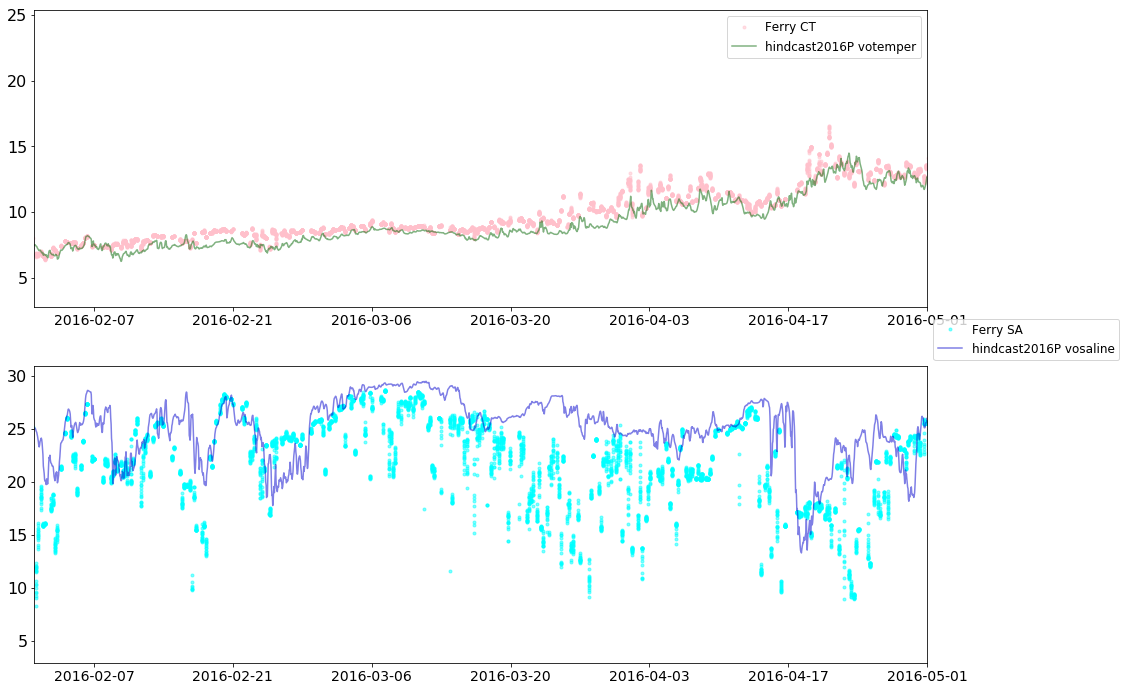

In [63]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(2,1,figsize=(16,3*(len(plist))))

pl='S3'
idir=dirname1
f=ff[idir][pl]

ii=0
var='votemper'
p01=ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['CT']].values],'.',color='pink',alpha=.5,
               label='Ferry CT')
p02=ax[ii].plot(times[idir],
            np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
            linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
ax[ii].legend(bbox_to_anchor=(1,1),fontsize=12)
ax[ii].set_xlim(dt.datetime(2016,2,1),dt.datetime(2016,5,1))


ii=1
var='vosaline'
p01=ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['SA']].values],'.',color='aqua',alpha=.5,
               label='Ferry SA')
p02=ax[ii].plot(times[idir],
            np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
            linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
ax[ii].legend(bbox_to_anchor=(1,1),fontsize=12)
ax[ii].set_xlim(dt.datetime(2016,2,1),dt.datetime(2016,5,1))

In [64]:
dfp=df.copy(deep=True)

In [65]:
flist=['BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
      'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20160307T160215Z_20161019T064047Z-clean.csv',
      'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20161019T064056Z_20161115T220747Z-clean.csv']

In [69]:
dfs=list()
for ii in range(0,len(flist)):
    dfs.append(pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/'+flist[ii],
        skiprows=102,header=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC')))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [70]:
df=pd.concat(dfs,ignore_index=True)

In [71]:
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]
df=df.assign(dts=dts)
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')

In [72]:
iidfnd2=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)

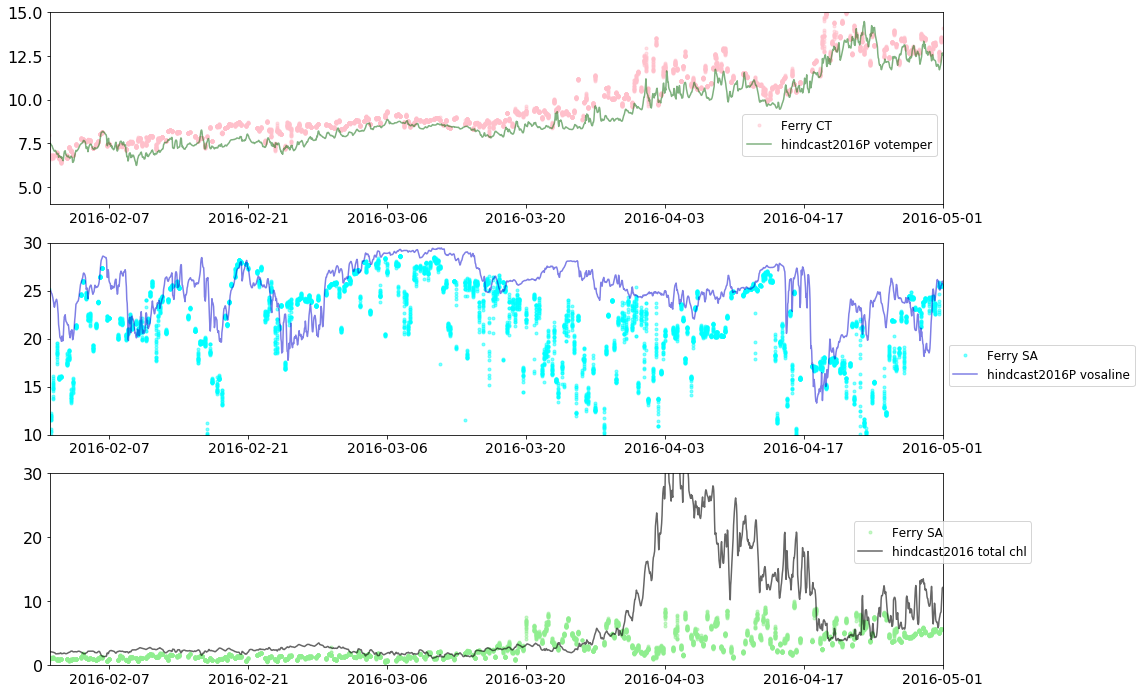

In [74]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(3,1,figsize=(16,3*(len(plist))))

pl='S3'
idir=dirname1
f=ff[idir][pl]

ii=0
var='votemper'
p01=ax[ii].plot(dfp.loc[iidfnd,['dts']],[float(ik[0]) for ik in dfp.loc[iidfnd,['CT']].values],'.',color='pink',alpha=.5,
               label='Ferry CT')
p02=ax[ii].plot(times[idir],
            np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
            linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
ax[ii].legend(bbox_to_anchor=(1,.5),fontsize=12)
ax[ii].set_xlim(dt.datetime(2016,2,1),dt.datetime(2016,5,1))
ax[ii].set_ylim(4,15)

ii=1
var='vosaline'
p01=ax[ii].plot(dfp.loc[iidfnd,['dts']],[float(ik[0]) for ik in dfp.loc[iidfnd,['SA']].values],'.',color='aqua',alpha=.5,
               label='Ferry SA')
p02=ax[ii].plot(times[idir],
            np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
            linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
ax[ii].legend(bbox_to_anchor=(1,.5),fontsize=12)
ax[ii].set_xlim(dt.datetime(2016,2,1),dt.datetime(2016,5,1))
ax[ii].set_ylim(10,30)

ii=2
idir=dirname2
f=ff[idir][pl]
p01=ax[ii].plot(df.loc[iidfnd2,['dts']],[float(ik[0]) for ik in df.loc[iidfnd2,['Chlorophyll_ug']].values],'.',color='lightgreen',alpha=.5,
               label='Ferry SA')
p02=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total chl')
ax[ii].set_xlim(dt.datetime(2016,2,1),dt.datetime(2016,5,1))
ax[ii].set_ylim(0,30)
ax[ii].legend(bbox_to_anchor=(1,.5),fontsize=12)
#p02=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
#                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')